# Databases3: Binary Search Trees

![](btree1.png)

![](btree2.png)

We've seen sorting so far. 

Whever we want to maintain our search dataset in memory, sorted, we use something like a Binary Search Tree instead. 

They perform well with dynamic data where insertions and deletions are frequent, because of the so called $O(height)$ guarantees. 

Some pros:

- can handle any size
- can handle dynamic data sets
- can handle many insertions and deletions
- can compute order statistics easily (for augmented trees)

If order is not needed though, you should be using a hash table.

From Skiena:

>We have seen data structures that allow fast search or flexible update, but not fast search and flexible update. Unsorted, doubly-linked lists supported insertion and deletion in 0(1) time but search took linear time in the worse case. Sorted arrays support binary search and logarithmic query times, but at the cost of linear-time update. Binary search requires that we have fast access to two elements specifically the median elements above and below the given node. To combine these ideas, we need a "linked list" with two pointers per node. This is the basic idea behind binary search trees. A rooted binary tree is recursively defined as either being (1) empty, or (2) consisting of a node called the root, together with two rooted binary trees called the left and right subtrees, respectively. The order among "brother" nodes matters in rooted trees, so left is different from right.



In [2]:
import uuid
class BinaryTree:
    def __init__(self, data, parent=None):
        self.data = data
        self.parent = parent
        self.uuid= uuid.uuid4()
        self.left = None
        self.right = None    
            
    def addLeftChild(self, data): 
        n = self.__class__(data, self)
        self.left = n
        return n
        
    def addRightChild(self, data):
        n = self.__class__(data, self)
        self.right = n
        return n
        
    def hasLeftChild(self):
        return self.left is not None

    def hasRightChild(self):
        return self.right is not None

    def hasAnyChild(self):
        return self.hasRightChild() or self.hasLeftChild()

    def hasBothChildren(self):
        return self.hasRightChild() and self.hasLeftChild()
    
    def hasNoChildren(self):
        return not self.hasRightChild() and not self.hasLeftChild()
    
    def isLeftChild(self):
        return self.parent and self.parent.left == self

    def isRightChild(self):
        return self.parent and self.parent.right == self

    def isRoot(self):
        return not self.parent

    def isLeaf(self):
        return not (self.right or self.left)
    
            
    def preorder(self):
        if self.isLeftChild():
            yield (self.parent, self, "left")
        elif self.isRightChild():
            yield (self.parent, self, "right")
        if self.hasLeftChild():
            for v in self.left.preorder():
                yield v
        if self.hasRightChild():
            for v in self.right.preorder():
                yield v

### Search Trees Supported operations

Whenever we encounter a new data structure we should write down their ops and the performance of these ops. 

The idea for BSTs is to be like a sorted array but provide fast(logarithmic) inserts and deletes.

- **Search** O(h)
- **Select**(Order Statistic) O(h) : Needs Augmented Tree, up from O(1) on sorted arrays
- **Minimum/Maximum** O(h), up from O(1) on sorted arrays
- **Predecessor/Successor** O(h), up from O(1) on sorted arrays
- **Rank** or Index O(h): Needs Augmented Tree
- **In-Order Traversal** O(n)
- **Insert** O(h)
- **Delete** O(h)

If we guarantee a balanced Tree:

$$ h = lg(n)$$

and thus most of these ops are $O(lg(n))$.

And we dont have to pay the piper on the sort...

![](bstproperty.png)

### The search tree property

- one node per key. we will handle duplicates internally.
- each node: left child, right child, parent pointers
- **Search Tree Property**

All keys left of a node are less than it. All keys right are greater.

### Choose Initial ops

Initial set of ops to support: insert, search, del,  sorted-iterator, successor, predecessor, min, max

(implementation based on interactivepython.org)

In [3]:
class BinarySearchTree(BinaryTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.count = 1

    def _insert_hook(self):
        pass
            
    def insert(self, data):
        if data < self.data:
            if self.hasLeftChild():
                self.left.insert(data)
            else:
                self.addLeftChild(data)
                self._insert_hook()
        elif data > self.data:
            if self.hasRightChild():
                self.right.insert(data)
            else:
                self.addRightChild(data)
                self._insert_hook()
        else: #duplicate value
            self.count += 1
            self._insert_hook()
            
    def search(self, data):
        if self.data == data:
            return self
        elif data < self.data and self.left:
            return self.left.search(data)
        elif data > self.data and self.right:
            return self.right.search(data)
        else:
            return None
        
    def delete(self, data):        
        if self.isRoot() and self.hasNoChildren() and self.data==data:#deleting the whole tree
            self.root=None#todo call a destructor that signals GC it can reap
            #self._update_sizes(up=False) #really tree is gone
            self._remove_hook()
        elif self.hasAnyChild():
            noder = self.search(data)
            if noder:
                self._remove(noder)
            else:
                raise ValueError("No such data {} in tree".format(data))
        else:
            raise ValueError("No such data {} in tree".format(data))

    def _remove_hook(self, up=False, by=1):
        pass
    
    def _remove(self, node):
        if node.isLeaf():
            if node.isLeftChild():
                node.parent.left = None
            else:
                node.parent.right = None
            #node._update_sizes(up=False, by=node.count)
            node._remove_hook(by=node.count)
            del node
        elif node.hasBothChildren():
            s = node.successor()
            #successor is guaranteed to have right child only
            s.spliceOut()
            #s._update_sizes(up=False, by=s.count)
            s._remove_hook(by=s.count)
            #handled more generally above
            #s.right.parent = s.parent
            #s.parent.left = s.right
            node.data = s.data
            #diff = s.count - node.count            
            #node._update_sizes(by=diff)
            node._remove_hook(up=True, by = s.count - node.count)
            node.count = s.count
            del s #the node became the successor
        else: # one child case
            if node.hasLeftChild():
                if node.isLeftChild():
                    node.left.parent = node.parent
                    node.parent.left = node.left
                elif node.isRightChild():
                    node.left.parent = node.parent
                    node.parent.right = node.left
                else: #root
                    self.root = node.left
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
            else:
                if node.isLeftChild():
                    node.right.parent = node.parent
                    node.parent.left = node.right
                elif node.isRightChild():
                    node.right.parent = node.parent
                    node.parent.right = node.right
                else: #root
                    self.root = node.right
                #node._update_sizes(up=False, by=node.count)
                node._remove_hook(by=node.count)
                del node
                    
    def findMin(self):
        minnode = self
        while minnode.hasLeftChild():
            minnode = minnode.left
        return minnode
    
    def findMax(self):
        maxnode = self
        while maxnode.hasRightChild():
            maxnode = maxnode.right
        return maxnode
    
    def successor(self):
        s = None
        if self.hasRightChild():
            s = self.right.findMin()
        else:
            if self.parent:
                if self.isLeftChild():
                    s = self.parent
                else:
                    self.parent.right=None
                    s = self.parent.successor()
                    self.parent.right=self
        return s
    
    def predecessor(self):
        p=None
        if self.hasLeftChild():
            p = self.left.findMax()
        else:
            if self.parent:
                if self.isRightChild():
                    p = self.parent
                else:
                    self.parent.left = None
                    p = self.parent.predecessor()
                    self.parent.left = self
        return p
            
    def spliceOut(self):
        if self.isLeaf():
            if self.isLeftChild():
                self.parent.left = None
            else:
                self.parent.right = None
        elif self.hasAnyChild():
            if self.hasLeftChild():
                if self.isLeftChild():
                    self.parent.left = self.left
                else:
                    self.parent.right = self.left
                self.left.parent = self.parent
            else:
                if self.isLeftChild():
                    self.parent.left = self.right
                else:
                    self.parent.right = self.right
                self.right.parent = self.parent
       

    #now implement various pythonic things
    
    def __iter__(self):
        if self is not None:
            if self.hasLeftChild():
                for node in self.left:
                    yield node
            for _ in range(self.count):
                yield self
            if self.hasRightChild():
                for node in self.right:
                    yield node
                    
    def __len__(self):#expensive O(n) version
        start=0
        for node in self:
            start += 1
        return start
    
    def __getitem__(self, i):
        return self.ithorder(i+1)
    
    def __contains__(self, data):
        return self.search(data) is not None

#### Our little plotting code...

Uses a pre-order traversal.

In [4]:
import subprocess
from IPython.display import Image
import os.path
def plotbtree(btree, fname, redo=False, augmented=False):
    if os.path.exists(fname+".png") and not redo:
        return Image(fname+".png")
    start="""
    digraph G {
    nodesep=0.3;
    ranksep=0.2;
    margin=0.1;
    node [shape=circle];
    edge [arrowsize=0.8];
    """
    end = "}"
    assert btree.isRoot(), "Must start at root"
    lines=""
    labeldict={}
    for t in btree.preorder():
        if not t[0].uuid in labeldict:
            labeldict[t[0].uuid]=t[0]
        if not t[1].uuid in labeldict:
            labeldict[t[1].uuid]=t[1]
        lines = lines + "\"{}\" -> \"{}\"[side={}];\n".format(t[0].uuid,t[1].uuid,t[2])
    if augmented:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">{},{}</FONT>>]".format(k,v.data,v.size, v.count) for (k, v) in labeldict.items()])+end
    else:
        end="\n".join(["\"{}\"[label=<{}<BR/><FONT POINT-SIZE=\"10\">count={}</FONT>>]".format(k,v.data,v.count) for (k, v) in labeldict.items()])+end
       
    start = start + lines +end
    with open(fname+".dot","w") as fd:
        fd.write(start)
    subprocess.call(['./treeplot.sh', fname])
    return Image(fname+".png")

### Insertion

In [5]:
ourlist=[17,5,35,2,11,29,38,9,16,7,8]
def btree_fromlist(inputlist, cls=BinarySearchTree):
    start=inputlist[0]
    rest=inputlist[1:]
    btree = cls(start)
    for item in rest:
        btree.insert(item)
    return btree

11


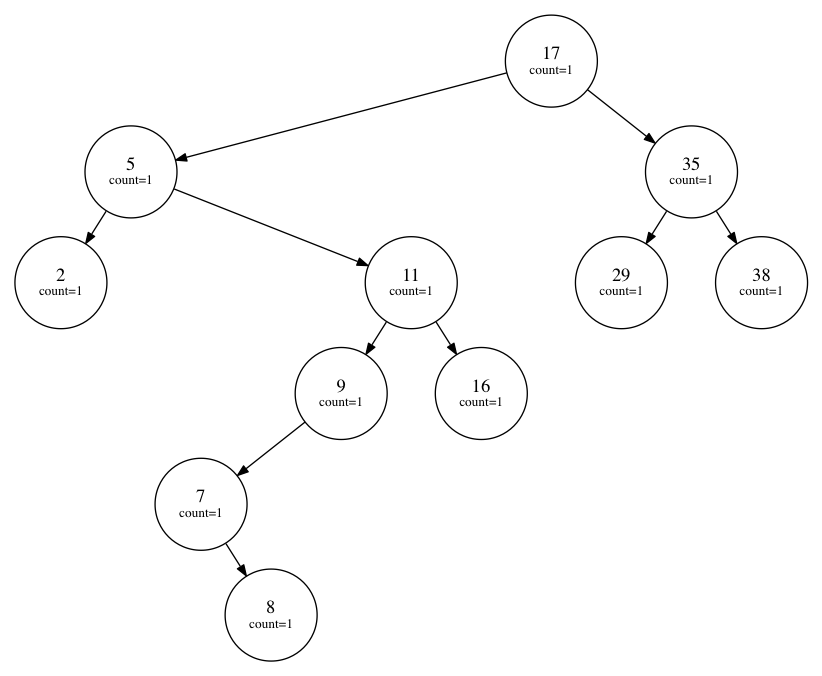

In [6]:
btree = btree_fromlist(ourlist)
print(len(btree))
plotbtree(btree,'oninserts', redo=True)

### Other ops: search/traversal

In [7]:
btree.search(8), btree.search(8).data

(<__main__.BinarySearchTree at 0x1059676a0>, 8)

### Traversal

We do an in-order traversal.

- start at the root
- recurse on left tree
- print out root
- recurse on right tree

n recursive calls, O(n) total

In [8]:
list(btree)#__iter__ implementation

In [9]:
for node in btree:
    print(node.data)

2
5
7
8
9
11
16
17
29
35
38


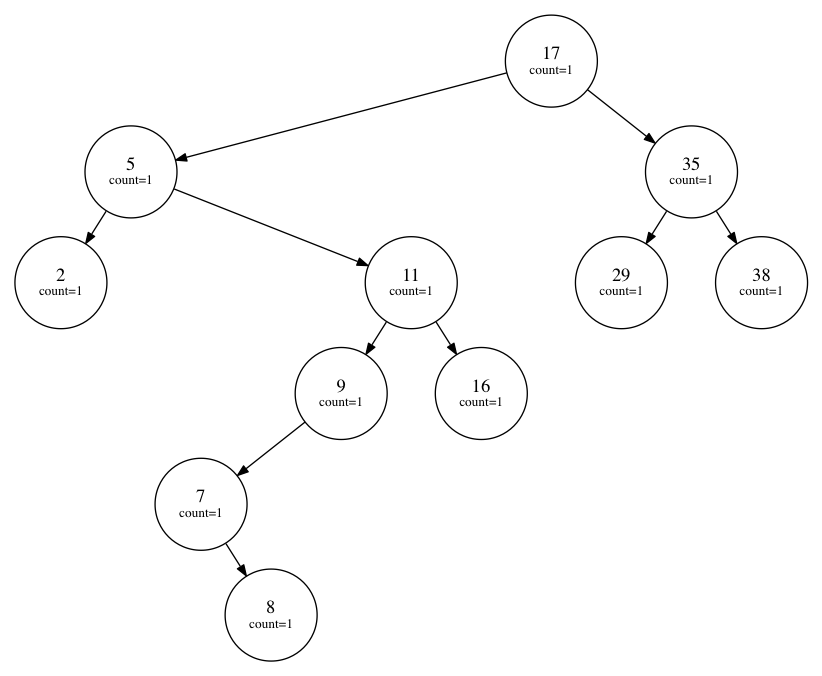

In [10]:
plotbtree(btree,'oninserts', redo=False)

### Other ops min/max/predecessor/successor

#### Minimum:

- start at root
- go left until you cant go anymore

#### Maximum

- start at root
- go right until you cant go anymore

In [11]:
btree.findMin().data, btree.findMax().data

(2, 38)

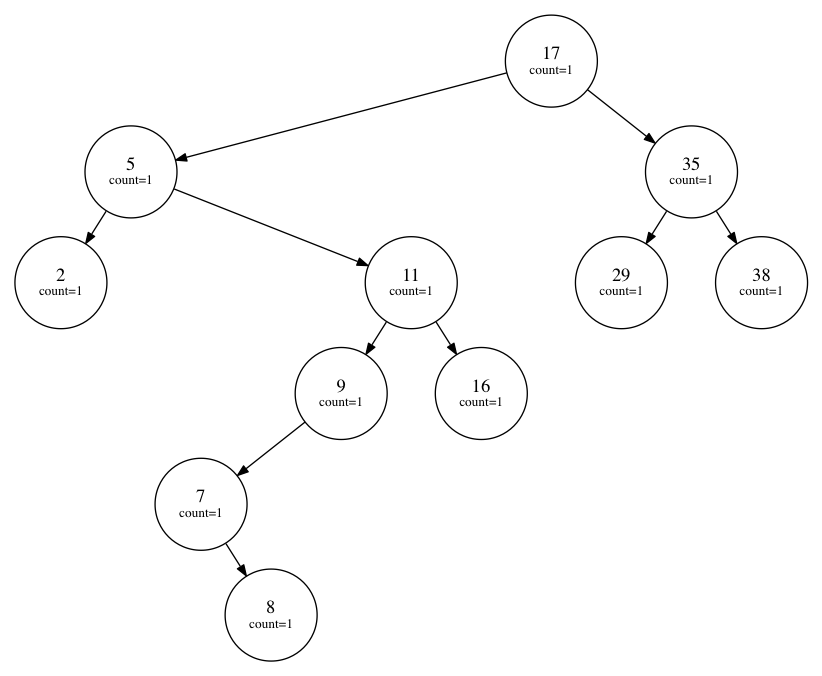

In [12]:
plotbtree(btree,'oninserts', redo=False)

#### Predecessor

- case 1: if left subtree non-empty, return the max key there
- case 2: follow parent pointers until you go to a key less than k. This happens the first time you "turn" left.

#### Successor

- easy case 1: if right subtree-non empty, find the min in it
- case 2: follow parent pointers until you go to any key greater than k. Will happen the first time you turn right.

In [13]:
eight = btree.search(8)
eight.predecessor().data, eight.successor().data

(7, 9)

In [14]:
btree.search(11).successor().data

16

In [15]:
print(btree.findMin().successor().data)
btree.findMin().predecessor().data

5


AttributeError: 'NoneType' object has no attribute 'data'

One should really provide a non-leaking way to get at the data.

### Deletion

Once we’ve found the node containing the key we want to delete, there are three cases that we must consider:

1. The node to be deleted has no children 
2. The node to be deleted has only one child 
3. The node to be deleted has two children 

#### No children

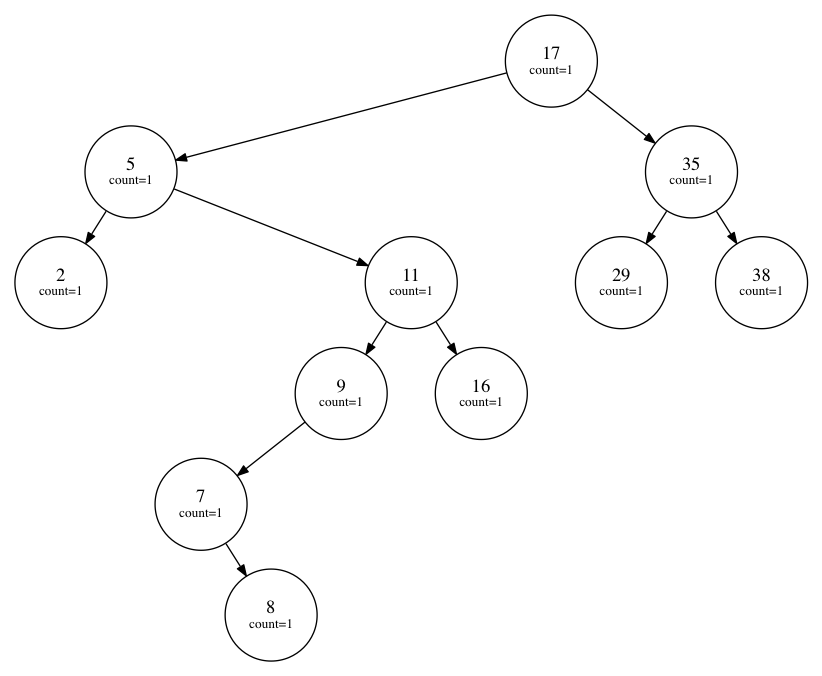

In [16]:
btree = btree_fromlist(ourlist)
plotbtree(btree,'oninserts', redo=False)

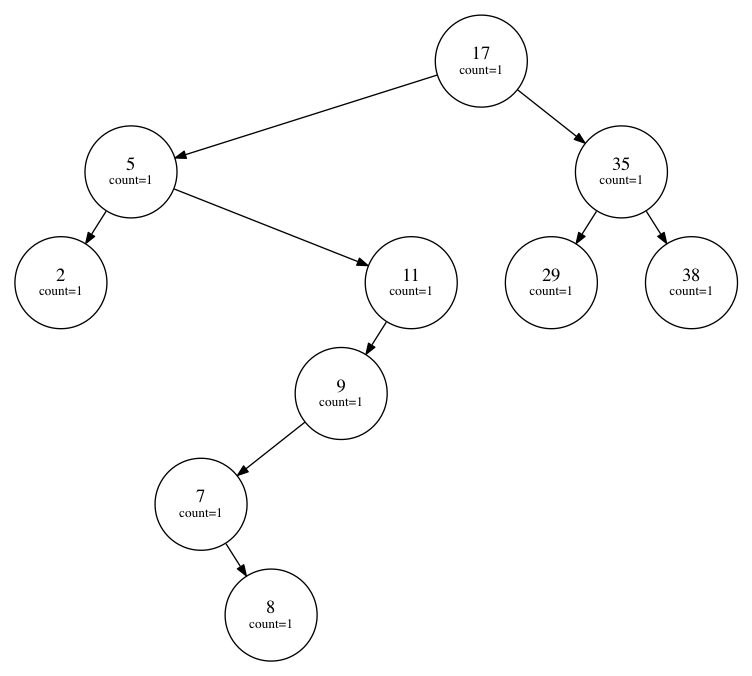

In [17]:
btree.delete(16)
plotbtree(btree,'ondelete16', redo=True)

#### One child

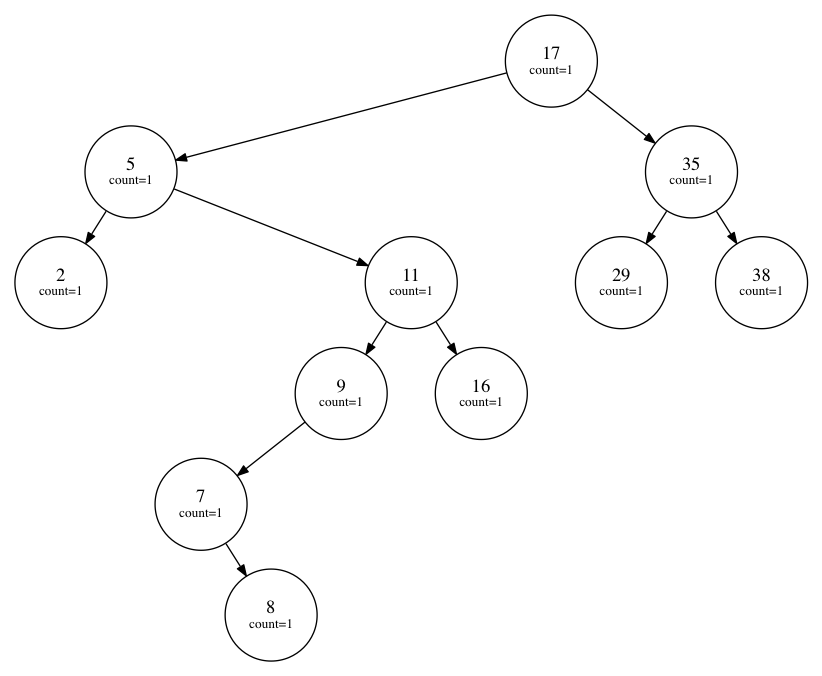

In [18]:
btree = btree_fromlist(ourlist)
plotbtree(btree,'oninserts', redo=False)

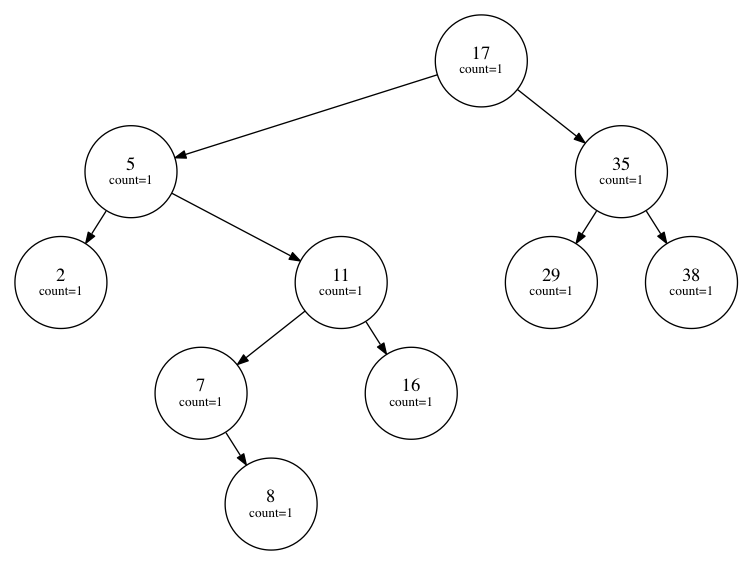

In [19]:
btree.delete(9)
plotbtree(btree,'ondelete9', redo=True)

#### Deletion, the hard case

- compute the successor
- splice out the successor
- swap the sliced out successor with the node to remove

Notice this maintains the search tree property!

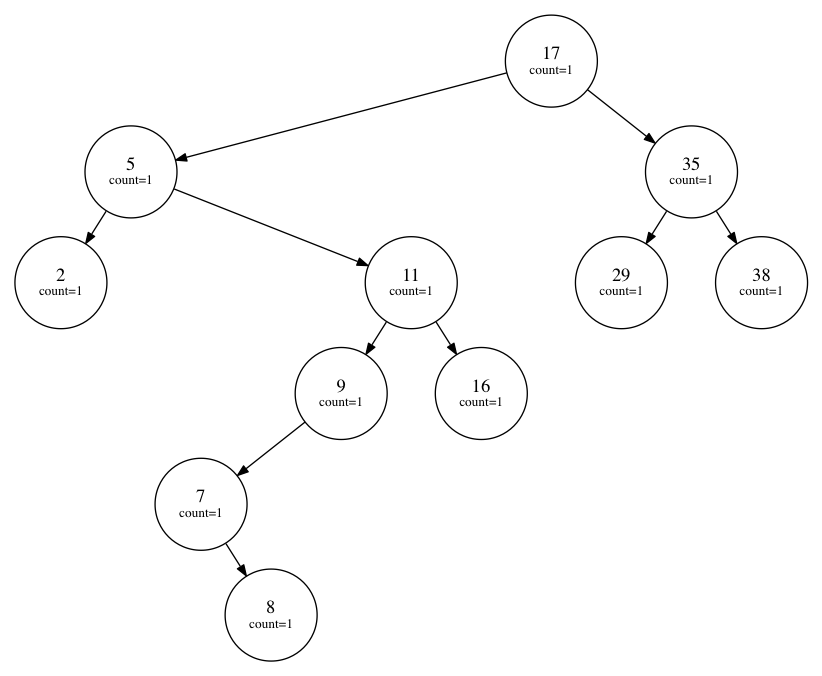

In [20]:
btree = btree_fromlist(ourlist)
plotbtree(btree,'oninserts')

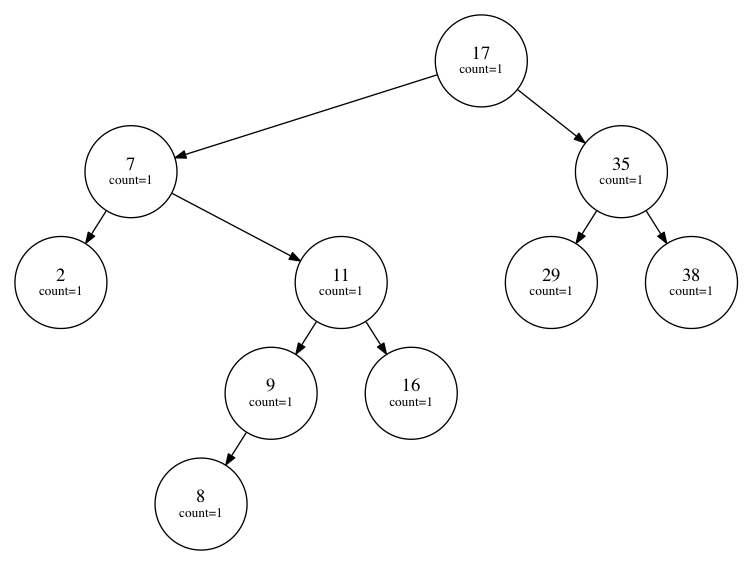

In [21]:
btree.delete(5)
plotbtree(btree,'ondelete5', redo=True)

### The case of duplicates

Aall of this works if the incoming data has duplicates. Our strategy is to maintain the duplicates in the same node

17


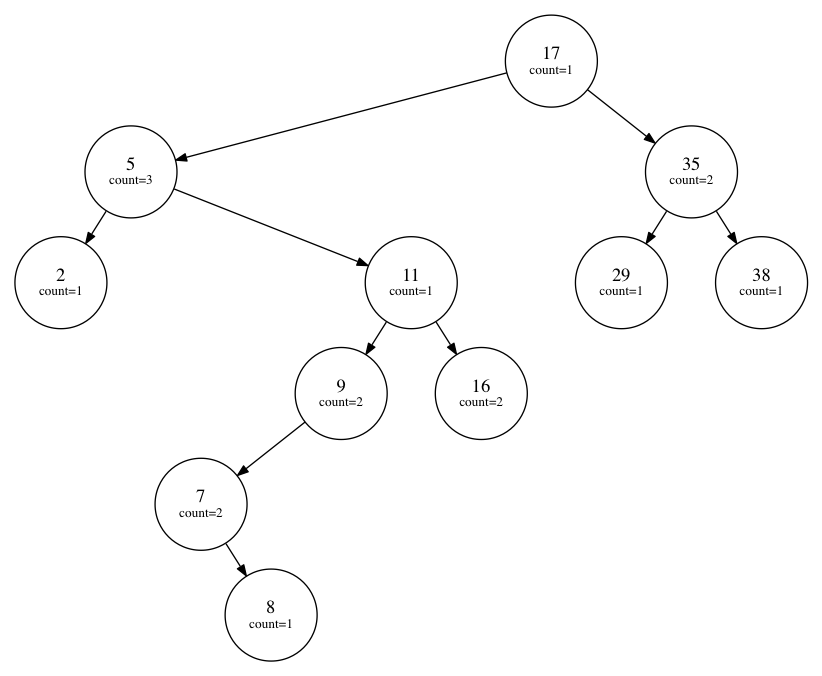

In [22]:
duplist=[17,5,35,2,11,29,38,9,16,7,8,7,35,5,16,9,5]
btreedup = btree_fromlist(duplist)
print(len(btreedup))
plotbtree(btreedup,'oninsertsdup', redo=True)

#### Ops with duplicates

In [23]:
btreedup.findMin().data, btreedup.findMax().data

(2, 38)

In [24]:
eight = btreedup.search(8)
eight.predecessor().data, eight.successor().data

(7, 9)

In [25]:
list(map(lambda x:x.data, list(btreedup)))

[2, 5, 5, 5, 7, 7, 8, 9, 9, 11, 16, 16, 17, 29, 35, 35, 38]

In [26]:
btreedup.search(5).data

5

#### Deletion with duplicates

The semantics here are that we remove ALL the duplicates, when we ask for the removal of a certain key. this makes our Binary Trees great for sets!

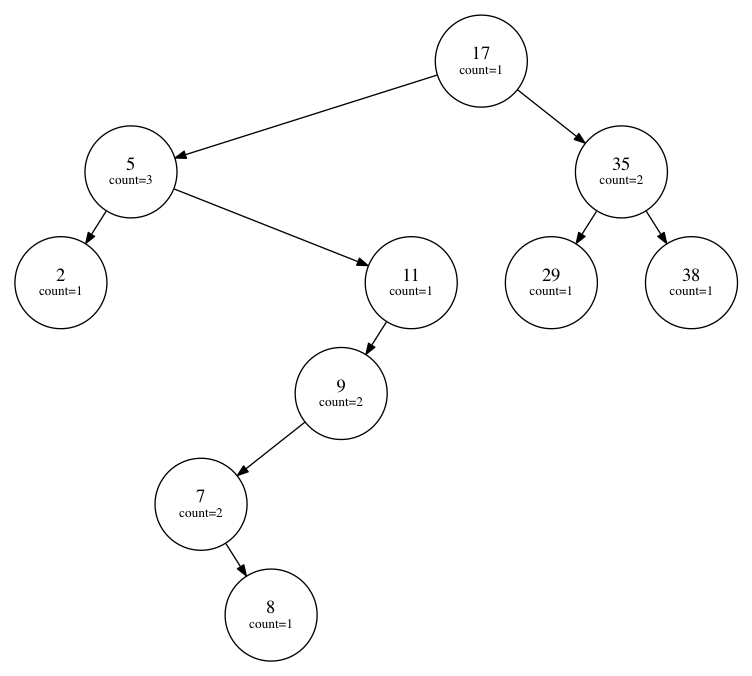

In [27]:
btreedup = btree_fromlist(duplist)
btreedup.delete(16)
plotbtree(btreedup,'ondelete16dup', redo=True)

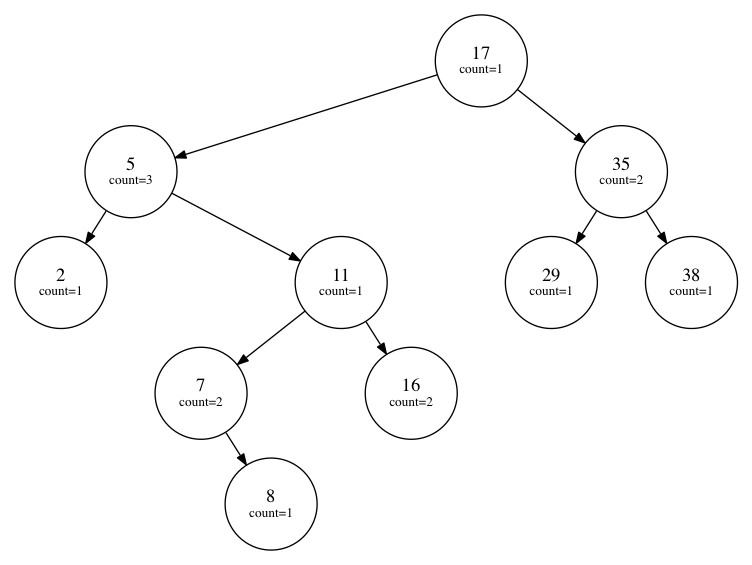

In [28]:
btreedup = btree_fromlist(duplist)
btreedup.delete(9)
plotbtree(btreedup,'ondelete9dup', redo=True)

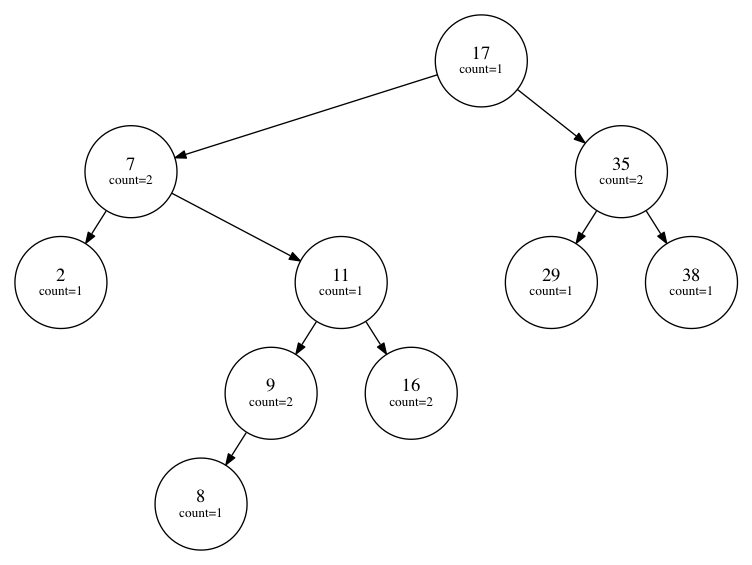

In [29]:
btreedup = btree_fromlist(duplist)
btreedup.delete(5)
plotbtree(btreedup,'ondelete5dup', redo=True)

In [30]:
class AugmentedBinarySearchTree(BinarySearchTree):
        
    def __init__(self, data, parent=None):
        super().__init__(data, parent)
        self.size = 1
        
    def _update_sizes(self, up=True, by=1):
        if up:
            inc = by
        else:
            inc = -by
        self.size += inc
        curr = self
        while curr.parent is not None:
            curr.parent.size += inc
            curr = curr.parent
       
    def _insert_hook(self):#insert up, by 1
        self._update_sizes()
            
    def _remove_hook(self, up=False, by=1):
        self._update_sizes(up, by)
        
    
    def ithorder(self, i): #starts from 1
        if self.hasLeftChild():
            a = self.left.size
        else:
            a = 0
        dupes = self.count - 1
        if  a+1 <= i  < a+1 + dupes:
            return self
        if i < a + 1 : #wont go here for size 0 on left
            return self.left.ithorder(i)
        elif  a+1 <= i  <= a+1 + dupes:
            return self
        else:#ok to have self.right here and not check right child
            return self.right.ithorder(i - a -1 -dupes)
       
    def _rankof(self, data):
        if self.data == data:#found at top
            if self.hasLeftChild():
                return self.left.size + self.count, self.count
            else:
                return self.count, self.count
        elif data < self.data and self.left:
            return self.left._rankof(data)
        elif data > self.data and self.right:
            rtup = self.right._rankof(data)
            if self.hasLeftChild():
                return self.count + self.left.size+rtup[0], rtup[1]
            else:
                return self.count + rtup[0], rtup[1]
        else:
            raise ValueError("{} not found".format(x))
            
    def rankof(self, data):
        ranktup = self._rankof(data)
        return [ranktup[0] - e for e in range(ranktup[1])]
    
    
    #now implement various pythonic things
    
    def __len__(self):
        return self.size

    
    def __getitem__(self, i):
        return self.ithorder(i+1)

#### Selection or the ith order statistic

This is an elegant algorithm, to get the ith order statistic:

1. start at root
2. let a=size_of(left subtree), or 0 if no left child
3. 
    - if i = a+1 return the key of the root
    - if i < a+1 recursively compute the ith order statistic for the BST rooted at the left child
    - if i > a+1 recursively compute the (i-(a+1))th statistic of the search tree rooted at the right child

In [31]:
btree = btree_fromlist(ourlist, AugmentedBinarySearchTree)
print([e.data for e in btree], len(btree))
for i in range(len(btree)):
    print(btree[i].data)

[2, 5, 7, 8, 9, 11, 16, 17, 29, 35, 38] 11
2
5
7
8
9
11
16
17
29
35
38


In [32]:
btreedup = btree_fromlist(duplist, AugmentedBinarySearchTree)
print([e.data for e in btreedup], len(btreedup), len(duplist))
for i in range(len(btreedup)):
    print(btreedup[i].data)

[2, 5, 5, 5, 7, 7, 8, 9, 9, 11, 16, 16, 17, 29, 35, 35, 38] 17 17
2
5
5
5
7
7
8
9
9
11
16
16
17
29
35
35
38


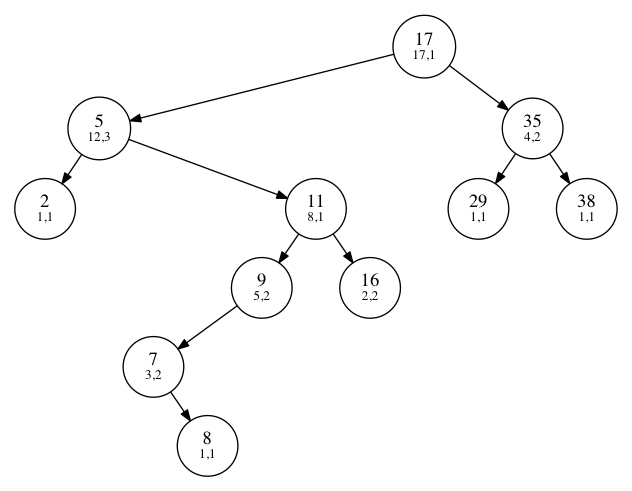

In [33]:
plotbtree(btreedup, 'oninsertsdupaug', augmented=True, redo=True)

### Balancing

Clearly these trees are not balanced. Most of these operations are O(height) of tree.

There are many ways to do this. One is a red-black tree.

The isea there is to assume you start with a balanced tree. When a new node is inserted it is marked red which means unbalanced node. When one more node is added we trigger a rebalance at the local parent which will propogate upwards if necessary, according to the following invariants.

- each node is either red or black
- root is black
- no two reds in a row => a red node may only have black children
- every root-null path has same number of black nodes (like in unsucessful search)

From http://matt.might.net/articles/red-black-delete/ (which you might want to read later for immutable red-black trees):

![](https://dl.dropboxusercontent.com/u/75194/redblackquilt2.jpeg)

One can show that every red black tree with n-nodes has $height <= 2lg(n+1)$

To achieve this one uses two transformations: recoloring and rotations. Google it. The implementation is complex!

![](https://dl.dropboxusercontent.com/u/75194/recoloring.png)

Recoloring

![](https://dl.dropboxusercontent.com/u/75194/leftrotation.png)

Left Rotation

We'll not go futher into red-black trees for now as we'll visit them later in your project when talking about functional data structures: Okasaki red black trees, aided by immutability, are simpler there!

https://dl.dropboxusercontent.com/u/75194/okasakiredblack.pdf

### Btrees

![](https://dl.dropboxusercontent.com/u/75194/btree1q.png)

(from https://loveforprogramming.quora.com/Memory-locality-the-magic-of-B-Trees)

- "A linked sorted distributed range array with predefined sub array size which allows searches, sequential access, insertions, and deletions in logarithmic time. "
- it is a generalization of a binary tree
- but the branching factor is much higher, and the depth thus smaller
- btrees break database into pages, and read-or-write one page at a time. A page is about 4k in size (see https://www.tutorialspoint.com/operating_system/os_virtual_memory.htm )
- leaf pages contain all the values and may represent a clustered index
- the pointers in a btree are disk based pointers

![](https://dl.dropboxusercontent.com/u/75194/btree1.png)
(from designing data intensive applications)

When we update a key, a split can happen

![](https://dl.dropboxusercontent.com/u/75194/btree2.png)

(from designing data intensive applications)

This is an in-place modification. The data structure is mutable. This can cause issues for transactions, and must be dealt with. 

Both splits and writing in-place are dangerous, so its normal for b-tree implementations to have a WAL, or write ahead log (such a log can also be used to manage transactions). Every operation on the btree is appended to this log file.

![](https://dl.dropboxusercontent.com/u/75194/btree2q.png)

In B+ trees, pointers amonst the leaf nodes make for an easier linear scan.

![](https://dl.dropboxusercontent.com/u/75194/bplus.png)

(from https://loveforprogramming.quora.com/Memory-locality-the-magic-of-B-Trees)